## Understanding large odds-ratios due to the choice of priors

This is a follow-up to the post [The relation between priors and the evidence](http://ga7g08.github.io/2015/08/19/Investigating-the-effect-of-the-prior-on-the-evidence) in which we generalise to $N_d$ dimensions. Note this work is a rather rough set of notes rather than anything formal. 

### Set-up
Take a data set $d_{ij}$ consisting of $N_d \times N$ data points where $N_d$ is the `dimension', and $N$ is the number of observations. 

$$\mathcal{L}(d| \mu, \sigma=1) = \prod_{j=1}^{N}\prod_{i=1}^{N_d} N(d_{ij}; \mu_i, \sigma=1) $$

Note that $\mu_i$ is a vector of $N_d$ dimensions and we use a fixed noise-component $\sigma=1$ across all data points.

We wish to compute
$$ Z = \int \mathcal{L}(d_ij| \mu_i, \sigma=1) \pi(\mu_i, \sigma=1) d\mu_i$$
and the idea is to vary the prior $\pi(\mu)$ to understand its effect on the evidence. 

### Helper function

We begin by defining a function which calculates the evidence and an estimate of the error using thermodynamic integration. Note that it can take any number of dimensions, but the prior must be the same for all $\mu_i$.

In [1]:
%matplotlib inline

import triangle
import emcee
import matplotlib.pyplot as plt
import numpy as np
import seaborn
plt.rcParams['axes.labelsize'] = 22

def logunif(x, a, b):
    above = x < b
    below = x > a
    if type(above) is not np.ndarray:
        if above and below:
            return -np.log(b-a)
        else:
            return -np.inf
    else:
        idxs = np.array([all(tup) for tup in zip(above, below)])
        p = np.zeros(len(x)) - np.inf
        p[idxs] = -np.log(b-a)[idxs]
        return p
    
def run(prior_type, x1, x2, x=[5.0], betamin=-3, ntemps=30):
    x1 = np.array(x1)
    x2 = np.array(x2)
    x = np.array(x)
    if prior_type == "norm":
        def logp_ind(mu):
            return -(mu - x1)**2 / (2*x2**2) - np.log(x2*np.sqrt(2*np.pi))
    elif prior_type == "unif":
        logp_ind = lambda mu: logunif(mu, x1, x2)
            
    def logl(params):
        sigma = 1
        mu = params
        single = -(x-mu)**2 / (2*sigma**2) - np.log(sigma*np.sqrt(2*np.pi))
        return np.sum(single)

    logp = lambda mu: np.sum(logp_ind(mu))
    
    nwalkers = 50
    ndim = x1.shape[-1]
    betas = np.logspace(0, betamin, ntemps)
    sampler = emcee.PTSampler(ntemps, nwalkers, ndim, logl=logl, logp=logp,
                              betas=betas)
    p0 = np.random.uniform(-0.1, 0.1, size=(ntemps, nwalkers, ndim))
    out = sampler.run_mcmc(p0, 200)
 
    ln_evidence, ln_error = sampler.thermodynamic_integration_log_evidence()
    evidence = np.exp(ln_evidence)
    error = np.exp(ln_evidence) * ln_error
 
    return ln_evidence/np.log(10), ln_error/np.log(10), sampler

### Example

Here we produce a data set with $N_d=2$ and $N=1$ using fake data from a standard normal distribution. Then we use a prior $\textrm{Unif}(-5, 5)$ for **both** $\mu_1$ and $\mu_2$ and compute the evidence. Analytically this should be $\frac{1}{10}\frac{1}{10}$ so $\log_{10}Z = -2 which is exactly what we find. 

In [63]:
ndim = 2
N = 1
data = np.random.normal(0, 1, (N, ndim))
evi, err, sampler = run('unif', [-5, -5], [5, 5], x=data)

Evidence = -2.00246854285


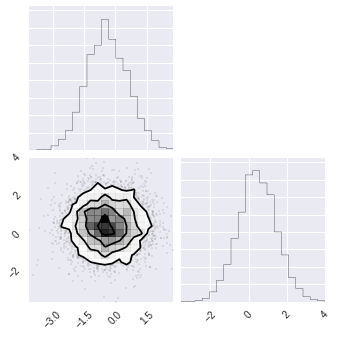

In [64]:
print "Evidence = {} +/- {}".format(evi, err)
triangle.corner(sampler.chain[0, :, 100:, :].reshape((-1, ndim)))
plt.show()

## Odds ratios

Now let us compute an odds ratio between the same data set with different priors. 

### Example: $N_d=1$

First we compare a uniform prior with a Gaussian prior which supports the data (in the sense that the prior does not contradict the data):

In [12]:
ndim = 1
N = 1
data = np.random.normal(0, 1, (N, ndim))

eviA, errA, _ = run('unif', [-5], [5], x=data)
eviB, errB, _ = run('norm', [0], [1], x=data)
print "Log10 odds-ratio = {}".format(eviA - eviB)

Log10 odds-ratio = -0.438380342294


So the odds-ratio prefers to the Gaussian prior. How about a Gaussian prior which is inconsistent with the data?

In [13]:
eviA, errA, _ = run('unif', [-5], [5], x=data)
eviB, errB, _ = run('norm', [3], [1], x=data)
print "Log10 odds-ratio = {}".format(eviA - eviB)

Log10 odds-ratio = 0.39202136832


Now we see that the odds-ratio favours the uniform prior!

## Large odds ratios

Okay so now we think the code is working, how can we generate *large* odds-ratios? Well let's turn up the number of
dimensions when the prior *doesn't* support the data:

In [38]:
ndim = 5
N = 1
data = np.random.normal(0, 1, (N, ndim))

eviA, errA, _ = run('unif', [-5, -5, -5, -5, -5], [5, 5, 5, 5, 5], x=data)
eviB, errB, _ = run('norm', [3, 3, 3, 3, 3], [.5, .5, .5, .5, .5], x=data)
print "Log10 odds-ratio = {}".format(eviA - eviB)

Log10 odds-ratio = 6.21260574701


This is fairly large at $10^{6}$

## Varying the number of data points

We will now compute odds-ratios between uniform and Gaussian priors varying both the number of data points and the number of dimensions. Note that the **same** prior is used for each new dimension.

### With a supporting prior

In [34]:
Ns = np.arange(50, 450, 100)

ndim = 1
log10evi_N1_S = []
log10err_N1_S = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5], [5], x=data)
    eviB, errB, _ = run('norm', [0], [1], x=data)
    log10evi_N1_S.append([eviA, eviB])
    log10err_N1_S.append([errA, errB])
    
ndim = 2
data = np.random.normal(0, 1, (N, ndim))
log10evi_N2_S = []
log10err_N2_S = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5, -5], [5, 5], x=data)
    eviB, errB, _ = run('norm', [0, 0], [1, 1], x=data)
    log10evi_N2_S.append([eviA, eviB])
    log10err_N2_S.append([errA, errB])
    
ndim = 3
data = np.random.normal(0, 1, (N, ndim))
log10evi_N3_S = []
log10err_N3_S = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5, -5, -5], [5, 5, 5], x=data)
    eviB, errB, _ = run('norm', [0, 0, 0], [1, 1, 1], x=data)
    log10evi_N3_S.append([eviA, eviB])
    log10err_N3_S.append([errA, errB])

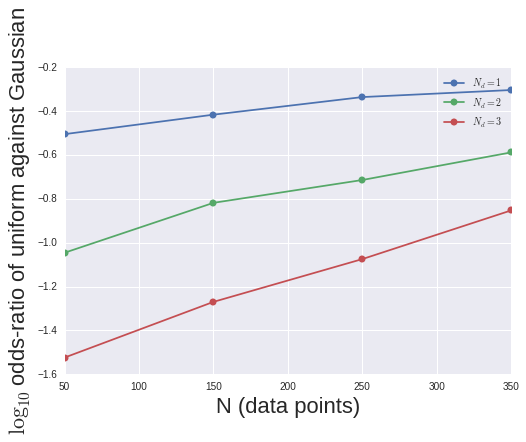

In [35]:
log10evi_N1_S = np.array(log10evi_N1_S)
log10err_N1_S = np.array(log10err_N1_S)
log10evi_N2_S = np.array(log10evi_N2_S)
log10err_N2_S = np.array(log10err_N2_S)
log10evi_N3_S = np.array(log10evi_N3_S)
log10err_N3_S = np.array(log10err_N3_S)

fig, ax = plt.subplots()
ax.plot(Ns, log10evi_N1_S[:, 0] - log10evi_N1_S[:, 1], "-o", label="$N_d=1$")
ax.plot(Ns, log10evi_N2_S[:, 0] - log10evi_N2_S[:, 1], "-o", label="$N_d=2$")
ax.plot(Ns, log10evi_N3_S[:, 0] - log10evi_N3_S[:, 1], "-o", label="$N_d=3$")

ax.legend()
ax.set_xlabel("N (data points)")
ax.set_ylabel("$\log_{10}$ odds-ratio of uniform against Gaussian")
plt.show()

### With the prior not supporting the data

In [23]:
Ns = np.arange(50, 450, 100)

ndim = 1
log10evi_N1_NS = []
log10err_N1_NS = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5], [5], x=data)
    eviB, errB, _ = run('norm', [3], [.5], x=data)
    log10evi_N1_NS.append([eviA, eviB])
    log10err_N1_NS.append([errA, errB])
    
ndim = 2
data = np.random.normal(0, 1, (N, ndim))
log10evi_N2_NS = []
log10err_N2_NS = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5, -5], [5, 5], x=data)
    eviB, errB, _ = run('norm', [3, 3], [.5, .5], x=data)
    log10evi_N2_NS.append([eviA, eviB])
    log10err_N2_NS.append([errA, errB])
    
ndim = 3
data = np.random.normal(0, 1, (N, ndim))
log10evi_N3_NS = []
log10err_N3_NS = []
for N in Ns:
    data = np.random.normal(0, 1, (N, ndim))
    eviA, errA, _ = run('unif', [-5, -5, -5], [5, 5, 5], x=data)
    eviB, errB, _ = run('norm', [3, 3, 3], [.5, .5, .5], x=data)
    log10evi_N3_NS.append([eviA, eviB])
    log10err_N3_NS.append([errA, errB])

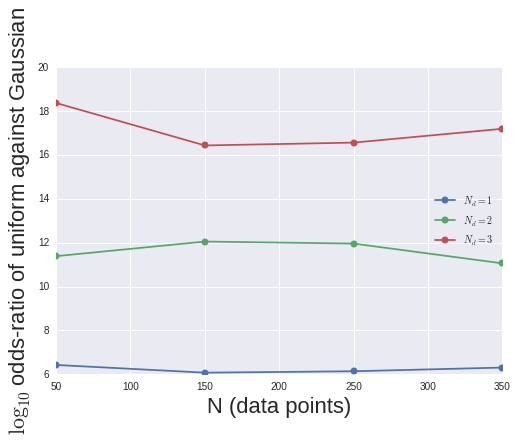

In [33]:
log10evi_N1_NS = np.array(log10evi_N1_NS)
log10err_N1_NS = np.array(log10err_N1_NS)
log10evi_N2_NS = np.array(log10evi_N2_NS)
log10err_N2_NS = np.array(log10err_N2_NS)
log10evi_N3_NS = np.array(log10evi_N3_NS)
log10err_N3_NS = np.array(log10err_N3_NS)

fig, ax = plt.subplots()
ax.plot(Ns, log10evi_N1_NS[:, 0] - log10evi_N1_NS[:, 1], "-o", label="$N_d=1$")
ax.plot(Ns, log10evi_N2_NS[:, 0] - log10evi_N2_NS[:, 1], "-o", label="$N_d=2$")
ax.plot(Ns, log10evi_N3_NS[:, 0] - log10evi_N3_NS[:, 1], "-o", label="$N_d=3$")

ax.legend(loc="best")
ax.set_xlabel("N (data points)")
ax.set_ylabel("$\log_{10}$ odds-ratio of uniform against Gaussian")